<h1>Data Preprocessing </h1>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
import random

In [ ]:
# Basic configuration
image_folder = "images"   # <- change
csv_file = "face_keypoints.csv"       # <- change
img_size = (128, 128)
batch_size = 32
seed = 42

In [4]:
# loading and cleaning data
def load_and_clean_df(csv_file, image_folder, drop_missing=True):
    df = pd.read_csv(csv_file)
    # expected columns: image_name, point_1_x, point_1_y, ..., point_5_x, point_5_y
    required_cols = ['image_name'] + [f'point_{i}_{ax}' for i in range(1,6) for ax in ('x','y')]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"CSV missing columns: {missing}")

    # Drop rows with missing keypoints (we used -1.0 as fallback earlier)
    if drop_missing:
        coord_cols = required_cols[1:]
        # drop any row where any coord < 0 (missing)
        df = df[~(df[coord_cols] < 0).any(axis=1)].copy()

    # Filter out rows where image file doesn't exist
    df['image_path'] = df['image_name'].apply(lambda n: os.path.join(image_folder, n))
    df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)
    return df


In [5]:

# Data Generator Class 
class KeypointSequence(Sequence):
    def __init__(self, df, batch_size=32, img_size=(128,128), augment=False, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

        # Landmark indices in our dataset order
        self.point_order = [1, 33, 263, 61, 291]  
        # Swap pairs when flipping horizontally
        self.swap_map = {1:1, 33:263, 263:33, 61:291, 291:61}

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_idx]

        images, keypoints = [], []

        for _, row in batch_df.iterrows():
            # Load image
            img_path = row['image_path'] if 'image_path' in row else os.path.join(image_folder, row['image_name'])
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Failed to load image: {img_path}")
                continue
            # img = cv2.imread(row['image_name'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img.astype("float32") / 255.0

            # Extract keypoints
            pts = np.array([
                [row['point_1_x'], row['point_1_y']],
                [row['point_2_x'], row['point_2_y']],
                [row['point_3_x'], row['point_3_y']],
                [row['point_4_x'], row['point_4_y']],
                [row['point_5_x'], row['point_5_y']]
            ], dtype="float32")

            # Augmentation: random horizontal flip
            if self.augment and random.random() < 0.5:
                img = cv2.flip(img, 1)  # horizontal flip

                # Flip X coordinates: x' = 1 - x
                pts[:, 0] = 1.0 - pts[:, 0]

                # Swap left-right keypoints
                flipped_pts = np.zeros_like(pts)
                for i, landmark_id in enumerate(self.point_order):
                    swap_id = self.swap_map[landmark_id]
                    swap_idx = self.point_order.index(swap_id)
                    flipped_pts[i] = pts[swap_idx]
                pts = flipped_pts

            images.append(img)
            keypoints.append(pts.flatten())

        return np.array(images), np.array(keypoints)
    
    def _load_image_and_kps(self, row):
        path = row['image_path']
        img = cv2.imread(path)
        if img is None:
            return None, None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize to img_size (if all images are already 128x128 this is harmless)
        img = cv2.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0  # normalize pixels to 0-1

        # load keypoints in order: [x1, y1, x2, y2, ..., x5, y5]
        kp = []
        for i in range(1,6):
            kp.append(row[f'point_{i}_x'])
            kp.append(row[f'point_{i}_y'])
        kp = np.array(kp, dtype=np.float32)

        # sanity check: coords should be normalized 0-1; if they look like pixels (>1.0),
        # assume they're in pixel units for img_size and normalize them.
        if kp.max() > 1.0:
            # assume coordinates are in pixels relative to img_size
            w, h = self.img_size[0], self.img_size[1]
            # x at even indices, y at odd indices
            kp[0::2] = kp[0::2] / w
            kp[1::2] = kp[1::2] / h

        # clamp to [0,1]
        kp = np.clip(kp, 0.0, 1.0)
        return img, kp    

    def _augment(self, image, keypoints):
        # Normalize image to [0,1]
        image = image.astype("float32") / 255.0

        if self.augment:
            # Random horizontal flip
            if random.random() < 0.5:
                image = cv2.flip(image, 1)  # flip horizontally

                # Flip X coords (x' = 1 - x, since keypoints are normalized)
                keypoints[:, 0] = 1.0 - keypoints[:, 0]

                # Swap left-right keypoints
                flipped_pts = np.zeros_like(keypoints)
                for i, landmark_id in enumerate(self.point_order):
                    swap_id = self.swap_map[landmark_id]
                    swap_idx = self.point_order.index(swap_id)
                    flipped_pts[i] = keypoints[swap_idx]
                keypoints = flipped_pts

            # (Optional) add more augmentations like brightness, rotation etc.
            # Example: random brightness jitter
            if random.random() < 0.3:
                factor = 0.7 + 0.6 * random.random()
                image = np.clip(image * factor, 0, 1)

        return image, keypoints
        

In [51]:
# Function to Split the data into train, test and val and pass it to the generator defined above
def create_generators(csv_file, image_folder, img_size=(128,128),
                      batch_size=32, test_ratio=0.1, val_ratio=0.1, augment=True, drop_missing=True):
    df = load_and_clean_df(csv_file, image_folder, drop_missing=drop_missing)
    print(f"Total valid samples after cleaning: {len(df)}")

        # Save cleaned dataset to new CSV
    clean_csv_file = "face_keypoints_cleaned.csv"
    df.to_csv(clean_csv_file, index=False)
    print(f"✅ Cleaned dataset saved to {clean_csv_file}")


    # first split out test
    df_trainval, df_test = train_test_split(df, test_size=test_ratio, random_state=seed)
    # split train and val from trainval
    val_relative = val_ratio / (1.0 - test_ratio)
    df_train, df_val = train_test_split(df_trainval, test_size=val_relative, random_state=seed)

    print("Splits -> train:", len(df_train), "val:", len(df_val), "test:", len(df_test))

    train_seq = KeypointSequence(df_train, batch_size=batch_size, img_size=img_size, augment=augment, shuffle=True)
    val_seq = KeypointSequence(df_val, batch_size=batch_size, img_size=img_size, augment=False, shuffle=False)
    test_seq = KeypointSequence(df_test, batch_size=batch_size, img_size=img_size, augment=False, shuffle=False)

    return train_seq, val_seq, test_seq

In [53]:
# Pass our dataset and other parameters to create_generators defined above
if __name__ == "__main__":
    train_seq, val_seq, test_seq = create_generators(
        csv_file=csv_file,
        image_folder=image_folder,
        img_size=img_size,
        batch_size=batch_size,
        test_ratio=0.1,
        val_ratio=0.1,
        augment=True,
        drop_missing=True
    )

    # peek at one batch
    # X_batch, y_batch = train_seq[0]
    # print("X batch shape:", X_batch.shape, "y batch shape:", y_batch.shape)


Total valid samples after cleaning: 69993
✅ Cleaned dataset saved to face_keypoints_cleaned.csv
Splits -> train: 55993 val: 7000 test: 7000


<h1> Model Building </h1>

In [58]:
import tensorflow as tf
from keras.applications import EfficientNetV2B0
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.losses import Huber

In [59]:
img_size = (128, 128, 3)  
num_keypoints = 5 * 2 

In [63]:
def build_model(input_shape=img_size, num_outputs=num_keypoints, freeze_backbone=True):
    # Load EfficientNetV2B0 backbone
    base_model = EfficientNetV2B0(input_shape=input_shape,
                                include_top=False,
                                weights='imagenet'
                                )
    base_model._name = "efficientnet_backbone"
    # Only freeze if pretrained weights are used
    # if freeze_backbone:
    #     for layer in base_model.layers:
    #         layer.trainable = False

    # Add regression head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_outputs, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=outputs, name="KeypointDetector")
    return model

In [ ]:
# class UnfreezeBackboneCallback(tf.keras.callbacks.Callback):
#     def __init__(self, unfreeze_at_epoch=5):
#         super().__init__()
#         self.unfreeze_at_epoch = unfreeze_at_epoch

#     def on_epoch_begin(self, epoch, logs=None):
#         if epoch == self.unfreeze_at_epoch:
#             print(f"\n🔓 Unfreezing backbone at epoch {epoch}")
#             backbone = self.model.get_layer("efficientnet_backbone")
#             for layer in backbone.layers:
#                 layer.trainable = True
#             self.model.compile(
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#                 loss=self.model.loss,
#                 metrics=self.model.metrics
#             )


In [64]:
# Build and compile the model 
model = build_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=Huber(),   # regression task
    metrics=["mae"]
)

# model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


<h1> Model Training </h1>

In [65]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from model_building import model
# from data_preprocessing import create_generators

In [66]:
train_seq, val_seq, test_seq = create_generators(
    csv_file="face_keypoints_cleaned.csv",   # use cleaned csv
    image_folder="images",      # update to your folder
    img_size=(128,128),
    batch_size=32,
    test_ratio=0.1,
    val_ratio=0.1,
    augment=True,   # augmentation only on train
    drop_missing=True
)

Total valid samples after cleaning: 69993
✅ Cleaned dataset saved to face_keypoints_cleaned.csv
Splits -> train: 55993 val: 7000 test: 7000


In [68]:
# Callback setup
checkpoint_path = "EfficientNetV2B0.h5"

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    # UnfreezeBackboneCallback(unfreeze_at_epoch=5)
]


In [69]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training complete! Best model saved at:", checkpoint_path)

d:\All\ASSIGNMENT\assignment\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - loss: 0.0098 - mae: 0.0901
Epoch 1: val_loss improved from None to 0.00016, saving model to EfficientNetV2B0.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1299s 725ms/step - loss: 0.0035 - mae: 0.0552 - val_loss: 1.5818e-04 - val_mae: 0.0129
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - loss: 3.9218e-04 - mae: 0.0206
Epoch 2: val_loss improved from 0.00016 to 0.00009, saving model to EfficientNetV2B0.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1265s 723ms/step - loss: 2.6692e-04 - mae: 0.0167 - val_loss: 9.0609e-05 - val_mae: 0.0094
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - loss: 1.0655e-04 - mae: 0.0105
Epoch 3: val_loss improved from 0.00009 to 0.00006, saving model to EfficientNetV2B0.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1215s 694ms/step - loss: 9.6304e-05 - mae: 0.0099 - val_loss: 5.9363e-05 - val_mae: 0.0073
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - loss: 7.3404e-05 - mae: 0.0086
Epoch 4: val_loss improved from 0.00006 to 0.00004, saving model to EfficientNetV2B0.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1191s 681ms/step - loss: 7.0556e-05 - mae: 0.0084 - val_loss: 4.4313e-05 - val_mae: 0.0062
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 6.3119e-05 - mae: 0.0079
Epoch 5: val_loss improved from 0.00004 to 0.00004, saving model to EfficientNetV2B0.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1214s 694ms/step - loss: 6.0990e-05 - mae: 0.0078 - val_loss: 4.3219e-05 - val_mae: 0.0061
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - loss: 5.8680e-05 - mae: 0.0076
Epoch 6: val_loss did not improve from 0.00004
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1135s 648ms/step - loss: 5.7895e-05 - mae: 0.0076 - val_loss: 4.4814e-05 - val_mae: 0.0062
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - loss: 5.4860e-05 - mae: 0.0075
Epoch 7: val_loss did not improve from 0.00004
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1268s 724ms/step - loss: 5.6679e-05 - mae: 0.0075 - val_loss: 6.7961e-05 - val_mae: 0.0077
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - loss: 5.9205e-05 - mae: 0.0074
Epoch 8: val_loss did not improve from 0.00004
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1246s 712ms/step - loss: 5.4439e-05 - mae: 0.0073 - val_loss: 8.6383e-05 - val_mae: 0.0088
Epoch 9/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - loss: 7.6272e-05 - mae: 0.0083
Epoch 9: val_lo

<h1> Visualization </h1>

In [70]:
import random
import matplotlib.pyplot as plt
from data_preprocessing import create_generators
import tensorflow as tf


In [71]:
csv_file = "face_keypoints_cleaned.csv"
image_folder = "images"
best_model = tf.keras.models.load_model("EfficientNetV2B0.h5", compile=False)
train_seq, val_seq, test_seq = create_generators(
    csv_file=csv_file,
    image_folder=image_folder,
    batch_size=32,
    test_ratio=0.1,
    val_ratio=0.1,
    augment=False,
    drop_missing=True
)


Total valid samples after cleaning: 69993
✅ Cleaned dataset saved to face_keypoints_cleaned.csv
Splits -> train: 55993 val: 7000 test: 7000


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


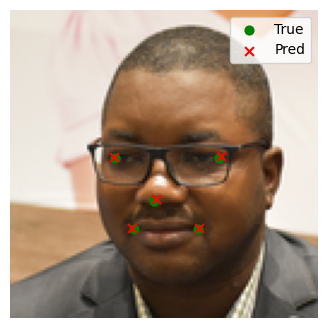

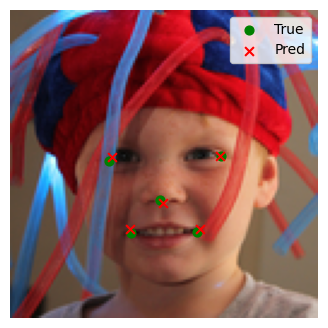

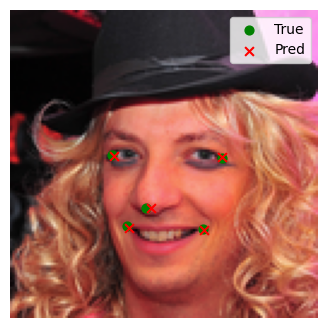

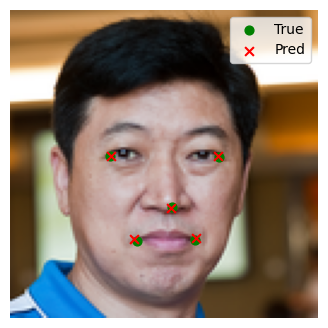

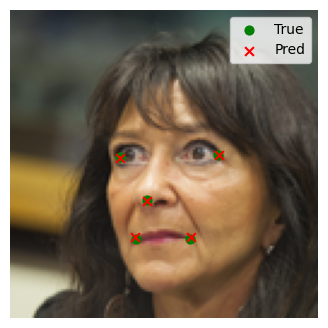

In [72]:

def visualize_overlay(model, test_seq, num_images=5, img_size=128):
    import random
    batch_idx = random.randint(0, len(test_seq) - 1)
    images, keypoints_true = test_seq[batch_idx]

    keypoints_pred = model.predict(images)

    for i in range(min(num_images, len(images))):
        img = images[i]
        true_pts = keypoints_true[i].reshape(-1, 2) * img_size
        pred_pts = keypoints_pred[i].reshape(-1, 2) * img_size

        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.scatter(true_pts[:, 0], true_pts[:, 1], c="g", s=40, marker="o", label="True")
        plt.scatter(pred_pts[:, 0], pred_pts[:, 1], c="r", s=40, marker="x", label="Pred")
        plt.legend()
        plt.axis("off")
        plt.show()
# Run overlay visualization
visualize_overlay(best_model, test_seq, num_images=5, img_size=128)

<h1> Model Evaluation </h1>

In [4]:
from data_preprocessing import create_generators
import tensorflow as tf

In [7]:
csv_file = "face_keypoints_cleaned.csv"
image_folder = "images"

train_seq, val_seq, test_seq = create_generators(
    csv_file=csv_file,
    image_folder=image_folder,
    batch_size=32,
    test_ratio=0.1,
    val_ratio=0.1,
    augment=False,
    drop_missing=True
)


Total valid samples after cleaning: 69993
✅ Cleaned dataset saved to face_keypoints_cleaned.csv
Splits -> train: 55993 val: 7000 test: 7000


In [8]:
best_model = tf.keras.models.load_model("2.h5", compile=False)

# Recompile (since loading with h5 sometimes loses compile info)
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [10]:
import random
import matplotlib.pyplot as plt
from data_preprocessing import create_generators
import tensorflow as tf

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


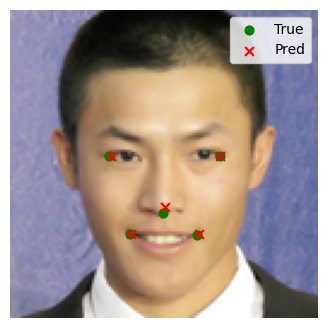

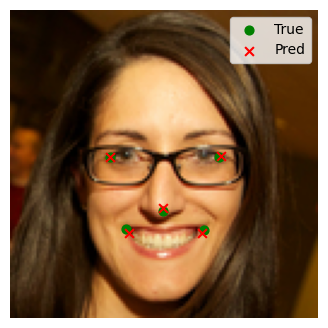

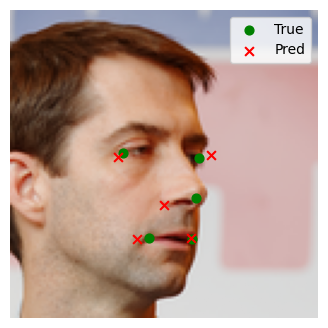

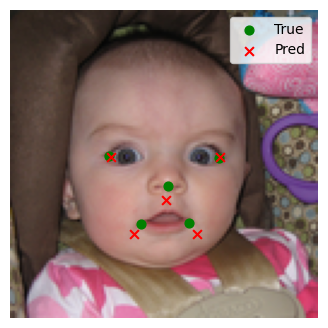

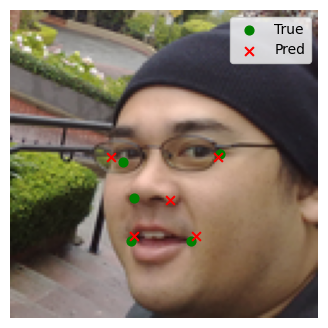

In [16]:

def visualize_overlay(model, test_seq, num_images=5, img_size=128):
    import random
    batch_idx = random.randint(0, len(test_seq) - 1)
    images, keypoints_true = test_seq[batch_idx]

    keypoints_pred = model.predict(images)

    for i in range(min(num_images, len(images))):
        img = images[i]
        true_pts = keypoints_true[i].reshape(-1, 2) * img_size
        pred_pts = keypoints_pred[i].reshape(-1, 2) * img_size

        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.scatter(true_pts[:, 0], true_pts[:, 1], c="g", s=40, marker="o", label="True")
        plt.scatter(pred_pts[:, 0], pred_pts[:, 1], c="r", s=40, marker="x", label="Pred")
        plt.legend()
        plt.axis("off")
        plt.show()
# Run overlay visualization
visualize_overlay(best_model, test_seq, num_images=5, img_size=128)

In [13]:
test_loss, test_mae = best_model.evaluate(test_seq, verbose=1)
print(f"✅ Final Test Loss (MSE): {test_loss:.4f}")
print(f"✅ Final Test MAE (normalized): {test_mae:.4f}")

# Convert normalized MAE to pixels
img_size = 128
test_mae_pixels = test_mae * img_size
print(f"🎯 Final Test MAE in pixels: {test_mae_pixels:.2f} px")


d:\All\ASSIGNMENT\assignment\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 52s 233ms/step - loss: 3.7821e-04 - mean_absolute_error: 0.0130
✅ Final Test Loss (MSE): 0.0004
✅ Final Test MAE (normalized): 0.0130
🎯 Final Test MAE in pixels: 1.67 px


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


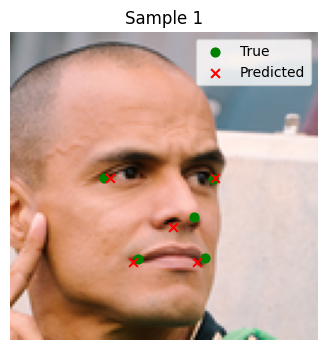

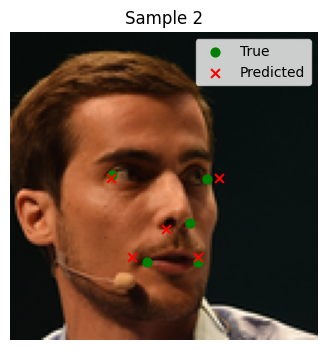

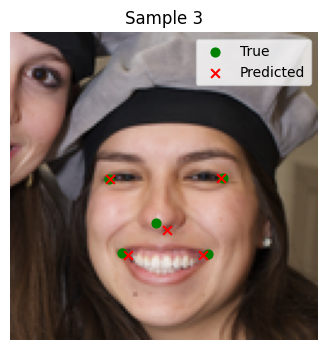

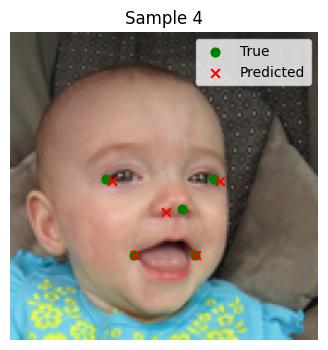

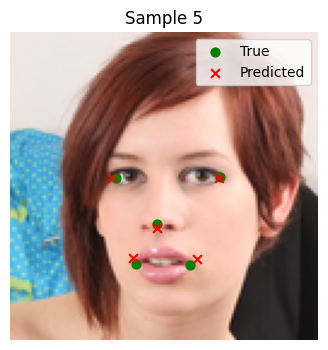

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch from test_seq
images, true_kps = test_seq[0]
pred_kps = best_model.predict(images)

# Plot first 5 samples
for i in range(5):
    img = images[i]
    true_pts = true_kps[i].reshape(-1, 2) * img_size
    pred_pts = pred_kps[i].reshape(-1, 2) * img_size

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.scatter(true_pts[:, 0], true_pts[:, 1], c='green', label='True', s=40)
    plt.scatter(pred_pts[:, 0], pred_pts[:, 1], c='red', label='Predicted', marker='x', s=40)
    plt.title(f"Sample {i+1}")
    plt.legend()
    plt.axis('off')
    plt.show()

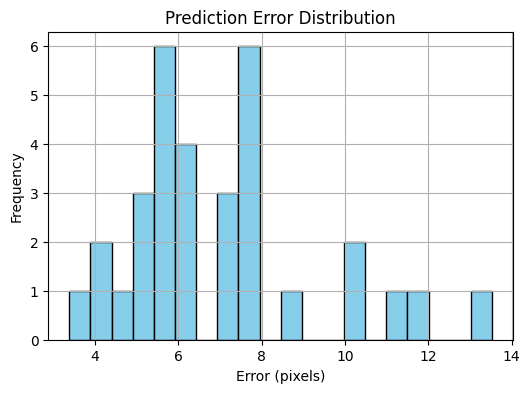

In [21]:
errors = np.linalg.norm(pred_kps - true_kps, axis=1) * img_size  # Euclidean error per sample

plt.figure(figsize=(6, 4))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Error (pixels)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

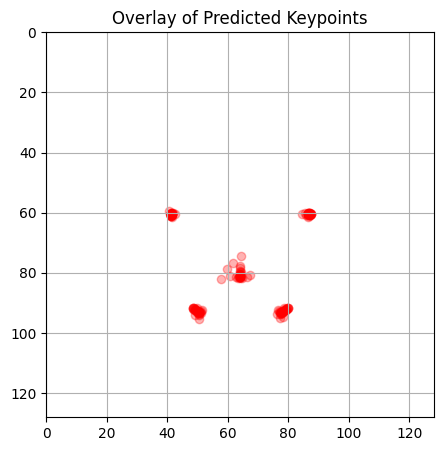

In [22]:
plt.figure(figsize=(5, 5))
for i in range(len(images)):
    pred_pts = pred_kps[i].reshape(-1, 2) * img_size
    plt.scatter(pred_pts[:, 0], pred_pts[:, 1], c='red', alpha=0.3)

plt.title("Overlay of Predicted Keypoints")
plt.xlim(0, img_size)
plt.ylim(img_size, 0)
plt.grid(True)
plt.show()

In [23]:
import numpy as np
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error

# Load model
model = tf.keras.models.load_model("EfficientNetV2B0.h5", compile=False)

# Load test data
_, _, test_seq = create_generators(
    csv_file="face_keypoints_cleaned.csv",
    image_folder="images",
    img_size=(128,128),
    batch_size=32,
    test_ratio=0.1,
    val_ratio=0.1,
    augment=False,
    drop_missing=True
)

# Collect predictions and ground truth
y_true, y_pred = [], []

for batch_x, batch_y in test_seq:
    preds = model.predict(batch_x)
    y_true.append(batch_y)
    y_pred.append(preds)

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Compute MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"📏 Mean Absolute Error (MAE): {mae:.4f}")

# Compute Huber Loss
huber = Huber()
huber_loss = huber(y_true, y_pred).numpy()
print(f"📉 Huber Loss: {huber_loss:.4f}")

Total valid samples after cleaning: 69993
✅ Cleaned dataset saved to face_keypoints_cleaned.csv
Splits -> train: 55993 val: 7000 test: 7000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━